<a href="https://colab.research.google.com/github/HaddoucheScript/Formulaire/blob/main/walmaert_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# Step 1: Load and Explore the Data
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/walmart_cleaned.csv')

# Convert Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Inspect the data
print(data.info())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    421570 non-null  int64         
 1   Store         421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   IsHoliday     421570 non-null  int64         
 4   Dept          421570 non-null  float64       
 5   Weekly_Sales  421570 non-null  float64       
 6   Temperature   421570 non-null  float64       
 7   Fuel_Price    421570 non-null  float64       
 8   MarkDown1     421570 non-null  float64       
 9   MarkDown2     421570 non-null  float64       
 10  MarkDown3     421570 non-null  float64       
 11  MarkDown4     421570 non-null  float64       
 12  MarkDown5     421570 non-null  float64       
 13  CPI           421570 non-null  float64       
 14  Unemployment  421570 non-null  float64       
 15  Type          421

This DataFrame appears to contain sales data for multiple stores over a period, including various factors that may influence sales such as holidays, temperature, fuel prices, markdowns, consumer price index, and unemployment rates. All columns are fully populated with no missing values.



In [ ]:
data.describe()

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,211611.321278,22.200546,2011-06-18 08:30:31.963375360,0.070358,44.260317,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,2.410088,136727.915739
min,0.000000,1.000000,2010-02-05 00:00:00,0.000000,1.000000,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,1.000000,34875.000000
25%,105782.250000,11.000000,2010-10-08 00:00:00,0.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,2.000000,93638.000000
50%,211603.500000,22.000000,2011-06-17 00:00:00,0.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,3.000000,140167.000000
75%,317424.750000,33.000000,2012-02-24 00:00:00,0.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,3.000000,202505.000000
max,423285.000000,45.000000,2012-10-26 00:00:00,1.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,3.000000,219622.000000
std,122195.149363,12.785297,NaN,0.255750,30.492054,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,0.666337,60980.583328


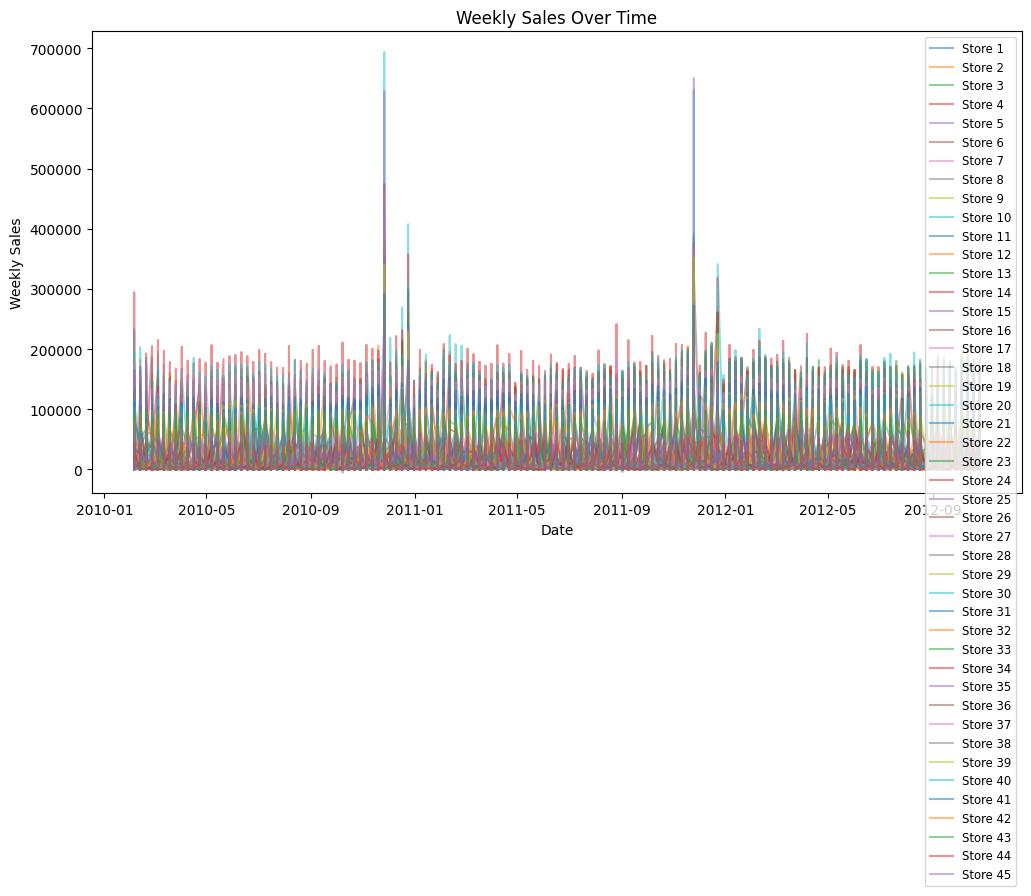

In [ ]:
# Plot Weekly_Sales over time for all stores
plt.figure(figsize=(12, 6))
for store in data['Store'].unique():
    store_data = data[data['Store'] == store]
    plt.plot(store_data['Date'], store_data['Weekly_Sales'], label=f'Store {store}', alpha=0.5)
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(loc='upper right', fontsize='small')
plt.show()



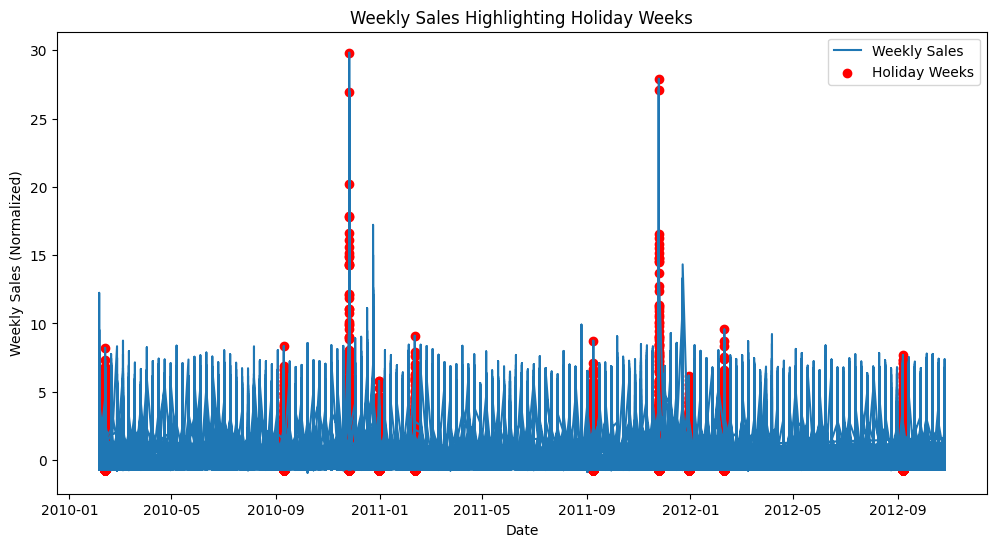

In [ ]:
# Step 2: Data Preprocessing
# Identify specific holidays
holiday_dates = {
    'Super Bowl': ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'],
    'Labour Day': ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'],
    'Thanksgiving': ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'],
    'Christmas': ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']
}

holiday_labels = []
for holiday, dates in holiday_dates.items():
    holiday_labels.extend([(pd.to_datetime(date), holiday) for date in dates])

# Add a holiday label column
data['Holiday'] = 'None'
for date, label in holiday_labels:
    data.loc[data['Date'] == date, 'Holiday'] = label

# Normalize numerical columns if required
numerical_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Step 3: Visualization
# Highlight holiday weeks on the plots
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Weekly_Sales'], label='Weekly Sales')
holiday_data = data[data['Holiday'] != 'None']
plt.scatter(holiday_data['Date'], holiday_data['Weekly_Sales'], color='red', label='Holiday Weeks')
plt.title('Weekly Sales Highlighting Holiday Weeks')
plt.xlabel('Date')
plt.ylabel('Weekly Sales (Normalized)')
plt.legend()
plt.show()



In [ ]:
# Step 4: Anomaly Detection

# 1. Statistical Method
# Calculate rolling mean and standard deviation
window = 4  # Rolling window size
data['Rolling_Mean'] = data.groupby('Store')['Weekly_Sales'].transform(lambda x: x.rolling(window=window).mean())
data['Rolling_Std'] = data.groupby('Store')['Weekly_Sales'].transform(lambda x: x.rolling(window=window).std())

# Identify anomalies
data['Stat_Anomaly'] = ((data['Weekly_Sales'] > data['Rolling_Mean'] + 3 * data['Rolling_Std']) |
                        (data['Weekly_Sales'] < data['Rolling_Mean'] - 3 * data['Rolling_Std']))



In [ ]:
# 2. Isolation Forest
# Prepare data for Isolation Forest
iso_data = data[numerical_cols].dropna()
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit and predict on the subset data
iso_data['IsoForest_Score'] = iso_forest.fit_predict(iso_data)
iso_data['IsoForest_Anomaly'] = iso_data['IsoForest_Score'] == -1

# Merge the results back to the original dataframe
data = pd.merge(data, iso_data[['IsoForest_Score', 'IsoForest_Anomaly']], left_index=True, right_index=True, how='left')



In [ ]:
# 3. Z-Score Method
# Calculate Z-Score
data['Z_Score'] = zscore(data['Weekly_Sales'].fillna(0))
data['Z_Anomaly'] = (data['Z_Score'] > 3) | (data['Z_Score'] < -3)



In [ ]:
# Step 5: Analyze the Anomalies
# Combine anomaly methods
data['Anomaly_Detected'] = data['Stat_Anomaly'] | data['IsoForest_Anomaly'] | data['Z_Anomaly']
anomalies = data[data['Anomaly_Detected']]

# Summary of anomalies
print(f"Total anomalies detected: {len(anomalies)}")
print(anomalies[['Date', 'Store', 'Weekly_Sales', 'Holiday', 'Anomaly_Detected']])



Total anomalies detected: 3021
            Date  Store  Weekly_Sales     Holiday  Anomaly_Detected
17    2010-02-05    1.0      3.481041        None              True
21    2010-02-05    1.0      3.161902        None              True
68    2010-02-05    1.0      4.355666        None              True
113   2010-02-12    1.0      2.710442  Super Bowl              True
129   2010-02-12    1.0      3.330935  Super Bowl              True
...          ...    ...           ...         ...               ...
52509 2011-02-04    6.0      3.160041        None              True
52539 2011-02-04    6.0      3.362601        None              True
52582 2011-02-11    6.0      2.925814  Super Bowl              True
52614 2011-02-11    6.0      2.919709  Super Bowl              True
52941 2011-03-18    6.0      3.039788        None              True

[3021 rows x 5 columns]


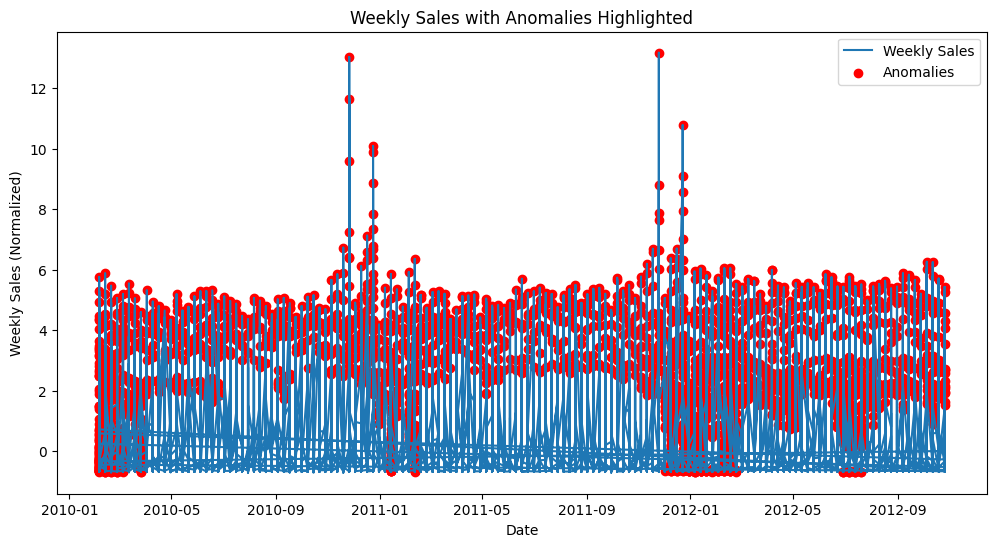

Anomalies during holidays: 388
            Date  Store  Weekly_Sales       Holiday
113   2010-02-12    1.0      2.710442    Super Bowl
129   2010-02-12    1.0      3.330935    Super Bowl
143   2010-02-12    1.0      4.470618    Super Bowl
2236  2010-09-10    1.0      4.157466    Labour Day
2253  2010-09-10    1.0      3.821358    Labour Day
...          ...    ...           ...           ...
51807 2010-11-26    6.0      3.419456  Thanksgiving
51812 2010-11-26    6.0      4.285936  Thanksgiving
52158 2010-12-31    6.0      3.273790     Christmas
52582 2011-02-11    6.0      2.925814    Super Bowl
52614 2011-02-11    6.0      2.919709    Super Bowl

[388 rows x 4 columns]


In [ ]:
# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Weekly_Sales'], label='Weekly Sales')
plt.scatter(anomalies['Date'], anomalies['Weekly_Sales'], color='red', label='Anomalies')
plt.title('Weekly Sales with Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('Weekly Sales (Normalized)')
plt.legend()
plt.show()

# Insights or Recommendations
# Investigate alignment of anomalies with holidays or unusual conditions
holiday_anomalies = anomalies[anomalies['Holiday'] != 'None']
print(f"Anomalies during holidays: {len(holiday_anomalies)}")
print(holiday_anomalies[['Date', 'Store', 'Weekly_Sales', 'Holiday']])
